Find coefficients for a linear regression model
y = w_0 + w_1 * x

Need to: 
- Plot the data (x = first col, y = second col)
- Use python to find the coefficients using:
- The normal equation
- Batch and stochastic gradient descent
- determine an appropriate termination condition ( when the cost function is less than a threshold / after a given number of iterations)
- print the cost function vs iterations for each mode; compare and discuss batch and stochastic models in terms of the accuracy and speed of convergence
- choose the best learning rate, for example, plot cost function vs learning rate to determine the best learning rate

In [49]:
import numpy as np
import matplotlib.pyplot as pt

In [18]:
x, y = np.loadtxt("data2.txt", delimiter=',', unpack=True)
x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)
print(f"The shape of x is: {x.shape}")
print(f"The shape of y is: {y.shape}")
print("The first few values in x:")
print(x[:5])
print("The first few values in y:")
print(y[:5])

The shape of x is: (97, 1)
The shape of y is: (97, 1)
The first few values in x:
[[6.1101]
 [5.5277]
 [8.5186]
 [7.0032]
 [5.8598]]
The first few values in y:
[[17.592 ]
 [ 9.1302]
 [13.662 ]
 [11.854 ]
 [ 6.8233]]


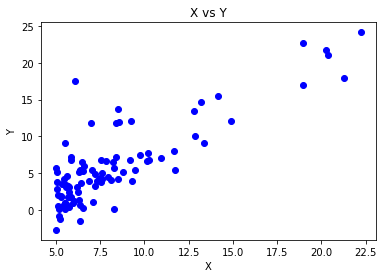

In [19]:
pt.plot(x, y, 'ob')
pt.title("X vs Y")
pt.xlabel("X")
pt.ylabel("Y")
pt.show()

## Closed Form Solution

The closed form solution for an unpenalized linear regression with least squares loss function:

$$(X_iW - Y_i)^2$$

where each $$X_i \epsilon R^{1x2} = [x_i;1]$$
and each $$W \epsilon R^{2x1} = [w;b]^T$$

and objective function:

$$min_W\sum_i(X_iW - Y_i)^2$$

is: 

$$W = (X^TX)^{-1}X^TY$$

Where X is an n-by-2 vector, Y is an n-by-1 vector, and W is a 2-by-1 vector

In [25]:
x_train = np.hstack((x, np.ones(x.shape)))
print(f"x_train shape: {x_train.shape}")

x_train shape: (97, 2)


In [32]:
xtx = np.dot(x_train.T, x_train)
print(xtx.shape)
xtx_inv = np.linalg.inv(xtx)
xty = np.dot(x_train.T, y)
print(xty.shape)
W = np.dot(xtx_inv, xty)
print(f"The shape of W: {W.shape}")
print(f"W: \n{W}")

(2, 2)
(2, 1)
The shape of W: (2, 1)
W: 
[[ 1.19303364]
 [-3.89578088]]


<ipython-input-39-47990874d5d1>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(x, y, 'ob', LineWidth=2)
<ipython-input-39-47990874d5d1>:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
<ipython-input-39-47990874d5d1>:14: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel("X", FontSize=16)
<ipython-input-39-47990874d5d1>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel("Y", FontSize=16)
<ipython-input-39-47990874d5d1>:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases l

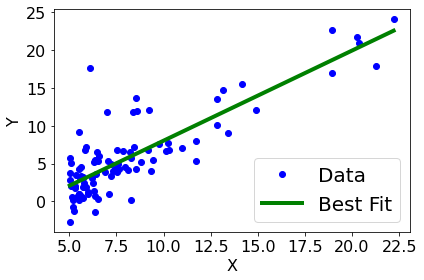

In [39]:
w1 = W[0]
w0 = W[1]

def get_regression_line(w0, w1, lower, upper):
    x = np.linspace(lower, upper, 100)
    return x, w1*x + w0

x_reg, y_reg = get_regression_line(w0, w1, min(x), max(x))

fig  = pt.figure(figsize=(6, 4))

line0, = pt.plot(x, y, 'ob', LineWidth=2)
line1, = pt.plot(x_reg, y_reg, 'g', LineWidth=4)
pt.xlabel("X", FontSize=16)
pt.ylabel("Y", FontSize=16)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0, line1], ["Data", "Best Fit"], fontsize=20)
pt.tight_layout()
pt.show()

## Gradient Descent

I have decided to add L2 regaularization to make convergence more stable

The objectve function with l2 regularization is defined as:
$$Q(W) = min_W||XW-Y||_2^2 + \frac{\lambda}{2}||W||_2^2$$

With variables:
$$W \epsilon R^{2} = [w;b]^T$$
$$X \epsilon R^{nx2} = [x;1]^T$$
$$Y \epsilon R^{nx1} = [y]^T$$

The gradient of the objectve function w.r.t W is:
$$\frac{\partial Q(W)}{\partial W} = X^TXW - Y^TX + \lambda W$$

In [351]:
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    """
     Calculate the objective Q_I and the gradient of Q_I
     Inputs:
         w: d-by-1 matrix
         xi: b-by-d matrix
         yi: b-by-1 matrix
         lam: scalar, the regularization parameter
         b: integer, the batch size
     Return:
         obj: scalar, the objective Q_i
         g: d-by-1 matrix, gradient of Q_i
         
    I have decided to add l2 regularization to make the algorithm more stable
    """
    # calculate the objective
#     print("xi")
#     print(xi)
#     print("w")
#     print(w)
    xw = np.dot(xi, w) # b-by-1 matrix
#     print("xw")
#     print(xw)
#     print("yi")
#     print(yi)
    xwy = xw - yi # b-by-1 matrix
#     print("xwy")
#     print(xwy)
    reg = (lam/2)*np.sum(w*w)
#     print("reg")
#     print(reg)
    obj = float(np.sum(xwy*xwy)) + reg# scalar
    
    # calculate the gradient
    xtxw = np.dot(xi.T, xw) # d-by-1 matrix

    g = xtxw - np.dot(yi.T, xi).T  + lam*w # d-by-1 matrix
    
    return obj, g

In [391]:
def mb_sgd(x, y, b, stepsize, lam, max_epoch=100, w=None, limit_output=False):
    """
     Mini-Batch SGD for solving logistic regression
     Inputs:
         x: n-by-d matrix
         y: n-by-1 matrix
         lam: scalar, the regularization parameter
         b: integer, the batch size
         stepsize: scalar
         max_epoch: integer, the maximal epochs
         w: d-by-1 matrix, initialization of w
     Return:
         w: the solution
         objvals: record of each iteration's objective value
    """
    n, d = x.shape
    objvals = np.zeros((max_epoch))
    
    if n % b != 0:
        print(x.shape)
        remainder = n%b
        print(remainder)
        x = x[:-remainder, ...]
        n, d = x.shape
        print(x.shape)
#         raise ValueError(f"Dataset must be evenly divisible into batches. Invalid batch length\nData length: {n}")
        
    if w is None:
        w = np.zeros((d, 1)) # zero initialization
        
    num_batches: int = n // b
    for e in range(max_epoch):
        rand_indices: np.ndarray = np.random.permutation(n)
        x_rand: np.ndarray = x[rand_indices, ...]
        y_rand: np.ndarray = y[rand_indices, ...]
        
        x_batch: np.ndarray = np.split(x_rand, num_batches)
        y_batch: np.ndarray = np.split(y_rand, num_batches)
        objval = 0 # accumulate objective values
        for i in range(num_batches): 
            obj, g = mb_stochastic_objective_gradient(w, x_batch[i], y_batch[i], lam, b)
            objval += obj
            w -= stepsize*g
        
        stepsize *= 0.9 # decrease step size
        objval /= num_batches
        objvals[e] = objval
        if not limit_output:
            print(f'Objective value at epoch e={e} is {str(np.round(objval, 5))}')
    print(f'Objective value at epoch e={max_epoch} is {str(np.round(objvals[-1], 5))}')
         
        
    
    return w, objvals

In [392]:
#### MB-SGD with batch size b=1
#### Equivalent to stochastic gradient descent
lam = 1E-6
b = 1
stepsize = 0.022 # you must tune this parameter
w, objvals_sgd = mb_sgd(x_train, y, b, stepsize, lam, max_epoch=100)
print(w)

Objective value at epoch e=0 is 167.90451
Objective value at epoch e=1 is 112.85098
Objective value at epoch e=2 is 199.93535
Objective value at epoch e=3 is 119.91113
Objective value at epoch e=4 is 262.61166
Objective value at epoch e=5 is 66.42306
Objective value at epoch e=6 is 105.63703
Objective value at epoch e=7 is 33.40495
Objective value at epoch e=8 is 22.97405
Objective value at epoch e=9 is 25.77838
Objective value at epoch e=10 is 19.20268
Objective value at epoch e=11 is 16.34478
Objective value at epoch e=12 is 17.0203
Objective value at epoch e=13 is 15.92832
Objective value at epoch e=14 is 12.0275
Objective value at epoch e=15 is 10.77377
Objective value at epoch e=16 is 11.82385
Objective value at epoch e=17 is 10.9596
Objective value at epoch e=18 is 9.90462
Objective value at epoch e=19 is 10.81517
Objective value at epoch e=20 is 10.98682
Objective value at epoch e=21 is 10.28799
Objective value at epoch e=22 is 9.26794
Objective value at epoch e=23 is 9.71292
Ob

## Iterations v Objective Function

<ipython-input-393-e0be8d3a6f54>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(epochs_sgd, objvals_sgd, '--b', LineWidth=4)
<ipython-input-393-e0be8d3a6f54>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Epochs', FontSize=20)
<ipython-input-393-e0be8d3a6f54>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-393-e0be8d3a6f54>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-393-e0be8d3a6f54>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two min

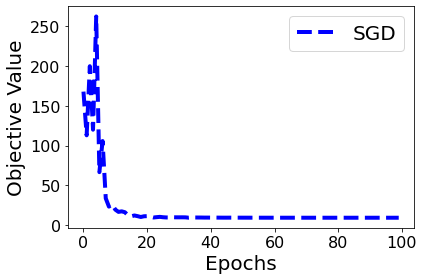

In [393]:
fig = pt.figure(figsize=(6, 4))
epochs_sgd = range(len(objvals_sgd))

line0, = pt.plot(epochs_sgd, objvals_sgd, '--b', LineWidth=4)
pt.xlabel('Epochs', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["SGD"], fontsize=20)
pt.tight_layout()
pt.show()

In [394]:
#### MB-SGD with batch size b=5
lam = 1E-6
b = 5
stepsize = 0.00325 # you must tune this parameter
w, objvals_mbsgd = mb_sgd(x_train, y, b, stepsize, lam, max_epoch=100)
print(w)

(97, 2)
2
(95, 2)
Objective value at epoch e=0 is 100.99256
Objective value at epoch e=1 is 89.33904
Objective value at epoch e=2 is 82.73879
Objective value at epoch e=3 is 88.73274
Objective value at epoch e=4 is 61.97537
Objective value at epoch e=5 is 64.29796
Objective value at epoch e=6 is 69.35564
Objective value at epoch e=7 is 58.01469
Objective value at epoch e=8 is 61.49904
Objective value at epoch e=9 is 53.89254
Objective value at epoch e=10 is 56.01231
Objective value at epoch e=11 is 53.38745
Objective value at epoch e=12 is 54.63229
Objective value at epoch e=13 is 55.35263
Objective value at epoch e=14 is 52.14027
Objective value at epoch e=15 is 55.33421
Objective value at epoch e=16 is 52.18128
Objective value at epoch e=17 is 52.25973
Objective value at epoch e=18 is 52.60088
Objective value at epoch e=19 is 51.62775
Objective value at epoch e=20 is 50.58551
Objective value at epoch e=21 is 51.29148
Objective value at epoch e=22 is 51.09838
Objective value at epoch 

<ipython-input-395-a7a79007e122>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(epochs_mbsgd, objvals_mbsgd, '--b', LineWidth=4)
<ipython-input-395-a7a79007e122>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Epochs', FontSize=20)
<ipython-input-395-a7a79007e122>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-395-a7a79007e122>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-395-a7a79007e122>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two

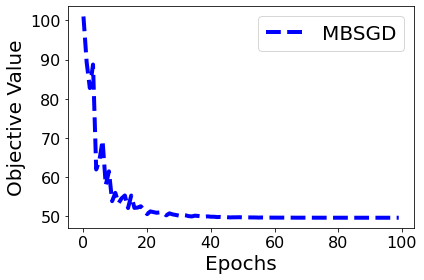

In [395]:
fig = pt.figure(figsize=(6, 4))
epochs_mbsgd = range(len(objvals_mbsgd))

line0, = pt.plot(epochs_mbsgd, objvals_mbsgd, '--b', LineWidth=4)
pt.xlabel('Epochs', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["MBSGD"], fontsize=20)
pt.tight_layout()
pt.show()

## Learning Rate vs Objective Function

In [411]:
#### MB-SGD with batch size b=1
#### Equivalent to stochastic gradient descent
lam = 1E-6
b = 1
objval_sgd = []
stepsizes = [0.030, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036]
for stepsize in stepsizes:
    w, objvals_sgd = mb_sgd(x_train, y, b, stepsize, lam, max_epoch=200, limit_output=True)
    objval_sgd.append(objvals_sgd[-1])

Objective value at epoch e=200 is 8.96572
Objective value at epoch e=200 is 8.95404
Objective value at epoch e=200 is 8.95415
Objective value at epoch e=200 is 119.92057
Objective value at epoch e=200 is 9.32963
Objective value at epoch e=200 is 336.50185
Objective value at epoch e=200 is 585.58285


<ipython-input-413-f25f71aa77f7>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(stepsizes, objval_sgd, '--b', LineWidth=4)
<ipython-input-413-f25f71aa77f7>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Learning Rates', FontSize=20)
<ipython-input-413-f25f71aa77f7>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-413-f25f71aa77f7>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-413-f25f71aa77f7>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed t

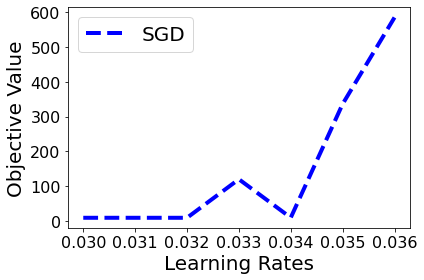

In [413]:
fig = pt.figure(figsize=(6, 4))

line0, = pt.plot(stepsizes, objval_sgd, '--b', LineWidth=4)
pt.xlabel('Learning Rates', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["SGD"], fontsize=20)
pt.tight_layout()
pt.show()

In [429]:
#### MB-SGD with batch size b=5
lam = 1E-6
b = 5
objval_mbsgd = []
stepsizes = [0.0010, 0.002, 0.0030, 0.0040, 0.0050, 0.0060, 0.0065]
for stepsize in stepsizes:
    w, objvals_mbsgd = mb_sgd(x_train, y, b, stepsize, lam, max_epoch=200, limit_output=True)
    objval_mbsgd.append(objvals_mbsgd[-1])

(97, 2)
2
(95, 2)
Objective value at epoch e=200 is 55.28108
(97, 2)
2
(95, 2)
Objective value at epoch e=200 is 52.48201
(97, 2)
2
(95, 2)
Objective value at epoch e=200 is 50.41045
(97, 2)
2
(95, 2)
Objective value at epoch e=200 is 48.85907
(97, 2)
2
(95, 2)
Objective value at epoch e=200 is 47.09744
(97, 2)
2
(95, 2)
Objective value at epoch e=200 is 46.73372
(97, 2)
2
(95, 2)
Objective value at epoch e=200 is 54.56218


<ipython-input-430-5f95d6bb4c6c>:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line0, = pt.plot(stepsizes, objval_mbsgd, '--b', LineWidth=4)
<ipython-input-430-5f95d6bb4c6c>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xlabel('Learning Rates', FontSize=20)
<ipython-input-430-5f95d6bb4c6c>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.ylabel('Objective Value', FontSize=20)
<ipython-input-430-5f95d6bb4c6c>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  pt.xticks(FontSize=16)
<ipython-input-430-5f95d6bb4c6c>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed

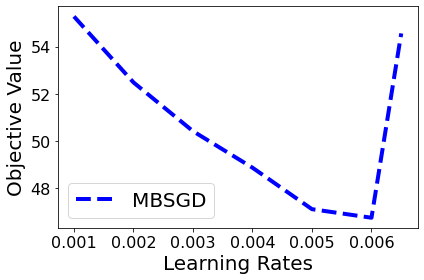

In [430]:
fig = pt.figure(figsize=(6, 4))

line0, = pt.plot(stepsizes, objval_mbsgd, '--b', LineWidth=4)
pt.xlabel('Learning Rates', FontSize=20)
pt.ylabel('Objective Value', FontSize=20)
pt.xticks(FontSize=16)
pt.yticks(FontSize=16)
pt.legend([line0], ["MBSGD"], fontsize=20)
pt.tight_layout()
pt.show()

## Discussion